### Autoencoders 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [2]:
torch.manual_seed(0)

In [38]:
transformation = transforms.Compose([transforms.ToTensor()])
batch_size = 100

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transformation, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transformation, download=True)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(train_dataset), shuffle=False)
X_tr, y_tr = next(iter(train_loader))

In [29]:
Noise_level = 0.35
Noisy_X_tr = torch.Tensor.clone(X_tr)
for index in range(X_tr.shape[0]):
    noise = Noise_level * np.random.normal(0, 1, size=X_tr[index][0].shape)
    Noisy_X_tr[index][0] = X_tr[index][0] + noise

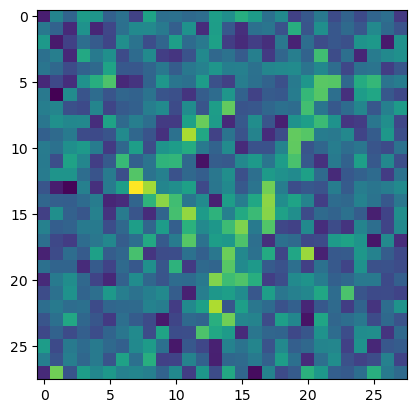

In [37]:
plt.imshow(Noisy_X_tr[1305][0])s